In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch

In [4]:
# load data
ninapro_root = "./Ninapro/DB8"
print(os.path.abspath(ninapro_root))

ex3_file = os.path.join(ninapro_root, "S1_E1_A1.mat")

data = loadmat(ex3_file)

# Inspect available keys, except the ones starting with "__"
print("Dataset variables:")
for key in data.keys():
    if not key.startswith("__"):
        print(key)

/data/Ninapro/DB8
Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


In [5]:
# First let's check the size of glove
glove_data = data["glove"]
print("Glove data dimension: {}".format(glove_data.shape))
print("Glove data type: {}".format(type(glove_data)))
#Yes indeed on the scheme of the instructions we can see that we have 18 types of glove variable

# First let's check the size of emg
emg_data = data["emg"]
print("emg data dimension: {}".format(emg_data.shape))
print("emg data type: {}".format(type(emg_data)))
#which is right, looking at the documentation we are meant to have 18 in EMG

#We need to use the joint angles 3,6,8,11,14
target_joints = [2, 5, 7, 10, 13]  # zero-indexed for Python
glove_fingers = glove_data[:, target_joints]
print("Glove of joint 3,6,8,11,14 data dimension: {}".format(glove_fingers.shape))
print("Glove of joint 3,6,8,11,14 data type: {}".format(type(glove_fingers)))

Glove data dimension: (2292526, 18)
Glove data type: <class 'numpy.ndarray'>
emg data dimension: (2292526, 16)
emg data type: <class 'numpy.ndarray'>
Glove of joint 3,6,8,11,14 data dimension: (2292526, 5)
Glove of joint 3,6,8,11,14 data type: <class 'numpy.ndarray'>


Text(0, 0.5, 'Amplitude')

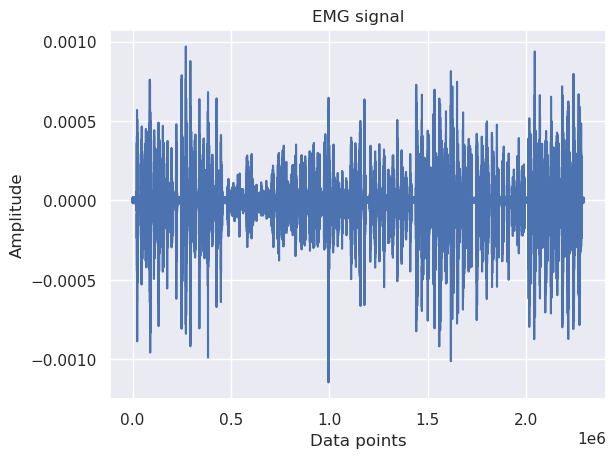

In [6]:
#plot 1st channel 
plt.close("all")
fig, ax = plt.subplots()
ax.plot(emg_data[:, 5])   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

Text(0, 0.5, 'Amplitude')

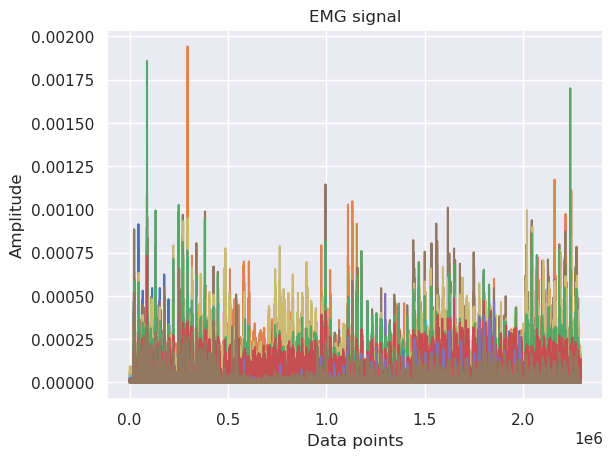

In [10]:
#We need to preprocess EMG and print the absolute value
plt.close("all")
fig, ax = plt.subplots()
ax.plot(np.abs(emg_data))   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

In [8]:
# Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.
freqs_pre, Pxx_pre = welch(emg_data_rect[:, 8], fs=2000, nperseg=512)

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

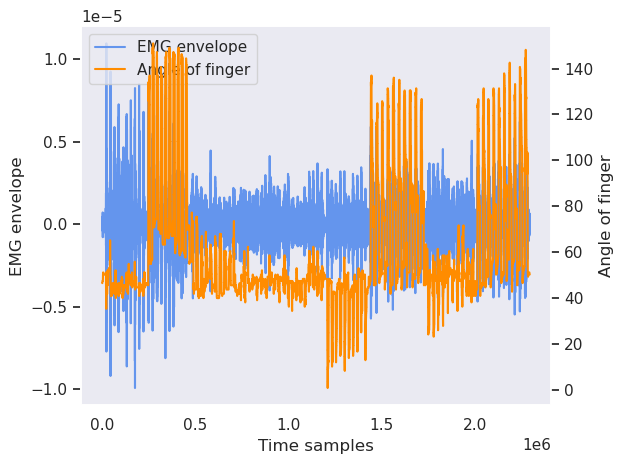

In [7]:
mov_mean_size = 400
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_data, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_data[:, 0], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

In [8]:
fs = 2000  # [Hz], from dataset description
emg_window_length_sec = 50e-3  # [s]
incremental_window_length_sec = 10e-3  # [s]

In [9]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [1]:
from sklearn.model_selection import train_test_split
# extract over lapping time windows on the whole dataset before splitting the dataset into train, validation and test
EMG_windows, Labels_windows = extract_time_windows_regression(EMG_envelopes, glove_data, fs, emg_window_length_sec, incremental_window_length_sec)

# randomly pick data for train, validation and test
EMG_train_windows, EMG_test_windows, Labels_train_windows, Labels_test_windows = train_test_split(EMG_windows, Labels_windows, test_size=0.2, random_state=151)

print(f"EMG train data shape: {EMG_train_windows.shape}, Train label shape: {Labels_train_windows.shape}")
print(f"EMG test data shape: {EMG_test_windows.shape}, Test label shape: {Labels_test_windows.shape}")

#shapes seems right, 16 for the 16 EMG channels
# 18 for the 18 joint

NameError: name 'extract_time_windows_regression' is not defined

In [11]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, the standard deviation and the maximum amplitude of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows, axis=1)
    EMG_std = np.std(EMG_windows, axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    
    Labels_mean = np.mean(Labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    return EMG_extracted_features, Labels_mean

In [ ]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))